#Importo le librerie e i pacchetti necessari

Prophet è una libreria open source per previsioni di serie temporali univariate sviluppata da Facebook.

Prophet implementa un modello di previsione delle serie temporali additivo e l'implementazione supporta trend, stagionalità e festività ed è progettato per essere facile e completamente automatico.

Per ulteriori info [[1]](https://peerj.com/preprints/3190.pdf)  [[2]](https://facebook.github.io/prophet/)




In [ ]:
import numpy as np
import pandas as pd

from fbprophet import Prophet
import itertools
from fbprophet.diagnostics import cross_validation, performance_metrics

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Definisco alcune funzioni

In [ ]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

In [ ]:
def plot_finale(train, validation, predicted_train_mean, predicted_val_mean):
  # prediction on TRAIN
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on TRAIN')
  plt.plot(train['y'], color='dimgrey', label='Real')
  plt.plot(predicted_train_mean, color='darkred', label='Predect', alpha=0.7)
  plt.ylabel('y')
  plt.legend()
  plt.show()

  # prediction on TRAIN and VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on TRAIN and VALIDATION')
  plt.plot(train['y'], color='dimgrey', label='Train')
  plt.plot(validation['y'], color='darkblue', label='Real')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.7)
  plt.ylabel('y')
  plt.legend()
  plt.show()

  # prediction on VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on VALIDATION')
  plt.plot(validation['y'], color='darkblue', label='Validation')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('y')
  plt.legend()
  plt.show()

  # figure on the first part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the first part of VALIDATION')
  plt.plot(validation['y'][:800], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[:800], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('y')
  plt.legend()
  plt.show()

  # figure on the last part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the last part of VALIDATION')
  plt.plot(validation['y'][-800:], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[-800:], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('y')
  plt.legend()
  plt.show()

#Importo i dati

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/MAGISTRALE/2 anno/1 semestre/streaming data management/progetto')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('data_complete.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data.index.freq='H'

In [ ]:
#The fit() function takes a DataFrame of time series data. The DataFrame must have a specific format. 
#The first column must have the name 'ds' and contain the date-times. The second column must have the name 'y' and contain the observations.
data.rename(columns={"Date_Hour": "ds", "Value": "y",}, inplace=True)

In [ ]:
#Create covid exogenous variable
data['covid']=0
data.loc[data[data['ds']=="2020-03-09 00:00:00"].index[0]:]['covid']=1

In [ ]:
#Train / validation split
train=data[data['ds']<="2020-04-30 23:00:00"]
validation=data[data['ds']>"2020-04-30 23:00:00"]

# Modello

In [ ]:
model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.01, seasonality_prior_scale=0.01)
model.add_regressor('covid')

# fit the model
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
# parameter of model seasonalities 
model.seasonalities

OrderedDict([('yearly',
              {'condition_name': None,
               'fourier_order': 10,
               'mode': 'additive',
               'period': 365.25,
               'prior_scale': 0.01}),
             ('weekly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 7,
               'prior_scale': 0.01}),
             ('daily',
              {'condition_name': None,
               'fourier_order': 4,
               'mode': 'additive',
               'period': 1,
               'prior_scale': 0.01})])

In [ ]:
in_sample_forecast = model.predict(train[['ds', 'covid']])
out_sample_forecast = model.predict(validation[['ds', 'covid']])

In [ ]:
print("MAE train:", mean_absolute_error(train['y'], in_sample_forecast['yhat']))
print("MAE validation:", mean_absolute_error(validation['y'].reset_index(drop=True), out_sample_forecast['yhat']))

MAE train: 366467.4
MAE validation: 545685.0


#Visualizzazioni

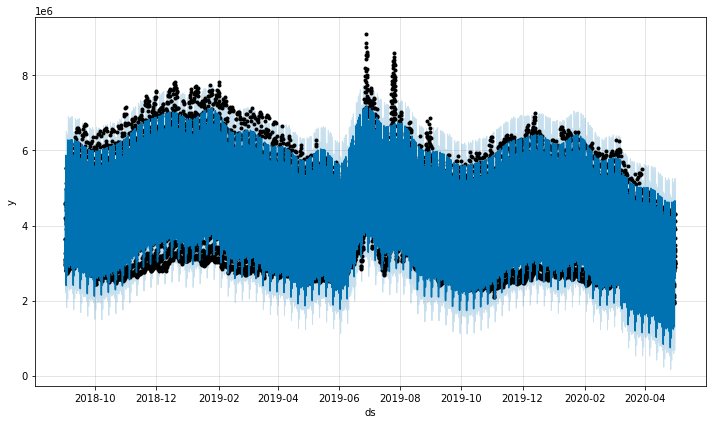

In [ ]:
fig1= model.plot(in_sample_forecast)

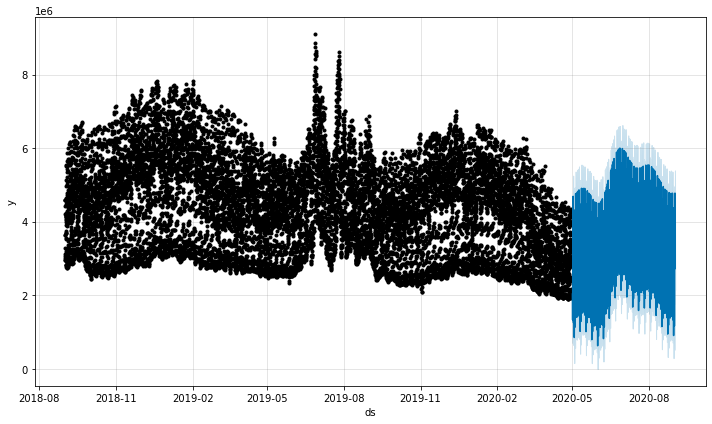

In [ ]:
fig2=model.plot(out_sample_forecast)

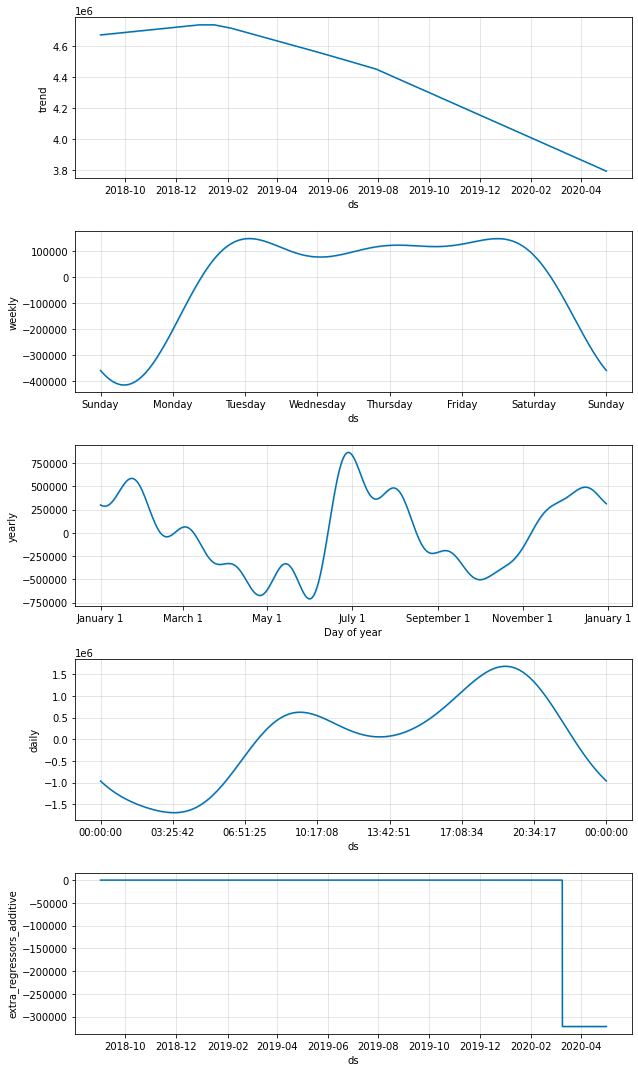

In [ ]:
fig3 = model.plot_components(in_sample_forecast)

In [ ]:
in_sample_forecast.set_index('ds', inplace=True)
out_sample_forecast.set_index('ds', inplace=True)
train.set_index('ds', inplace=True)
validation.set_index('ds', inplace=True)

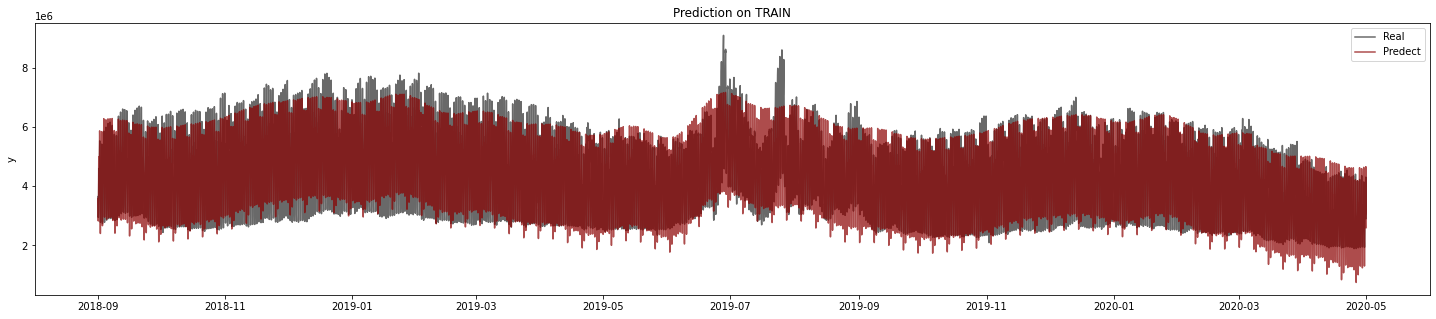

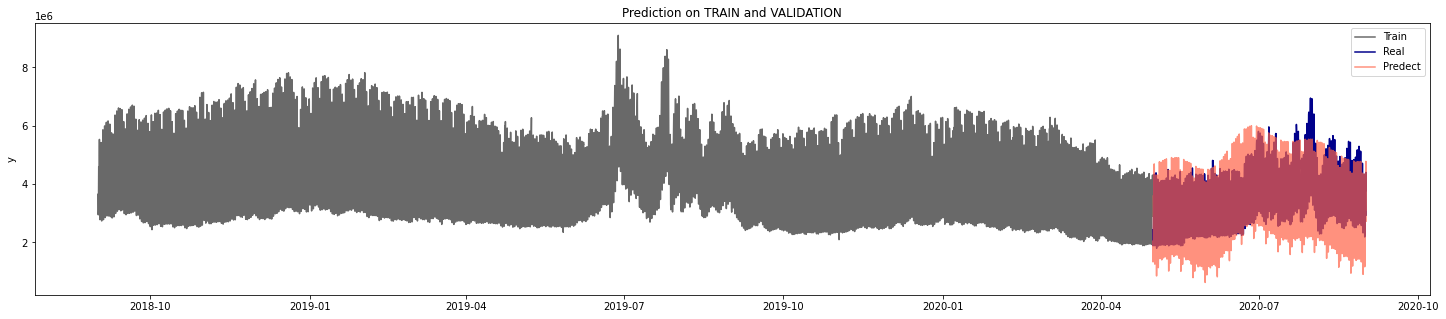

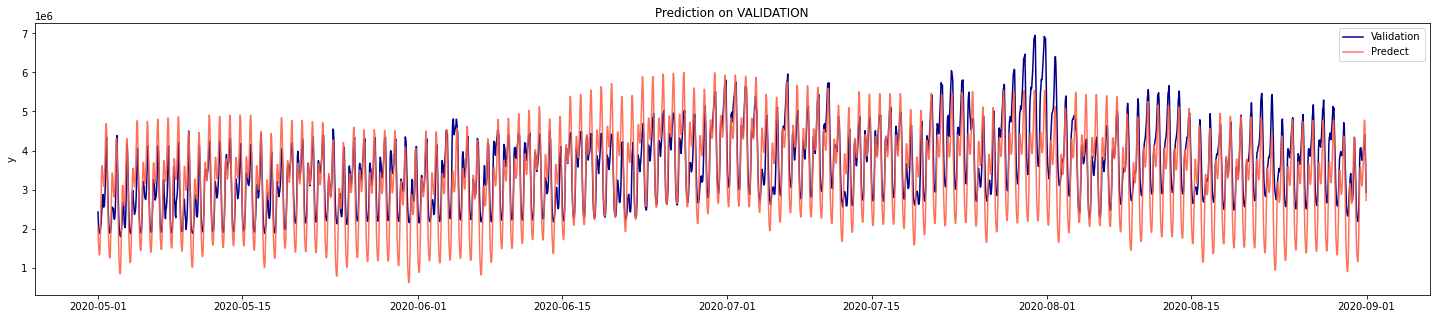

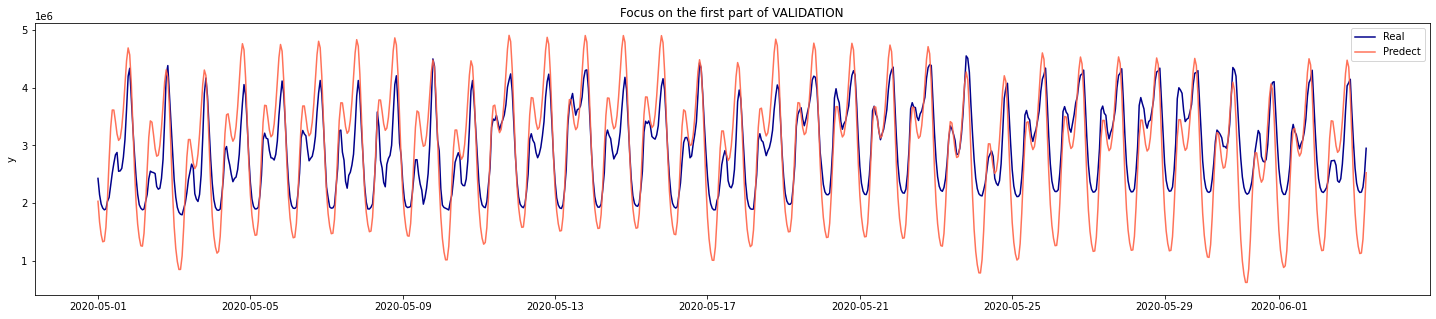

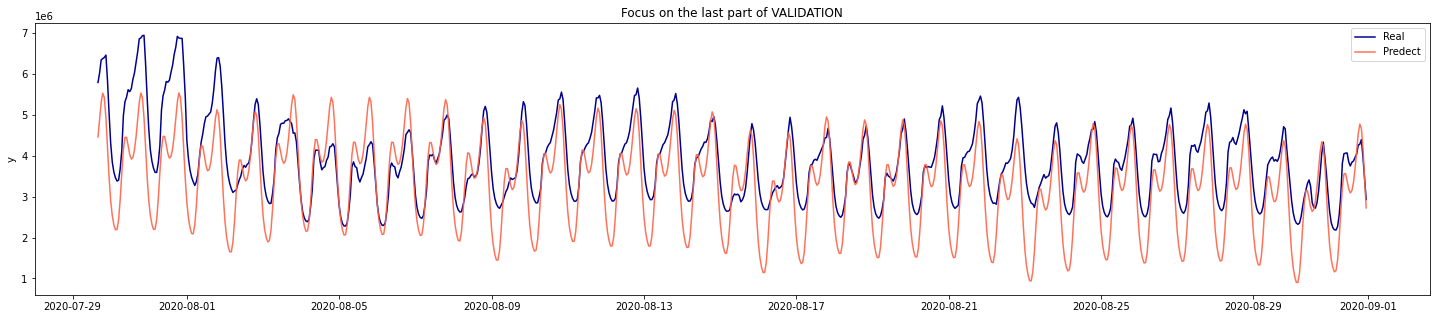

In [ ]:
plot_finale(train, validation, in_sample_forecast['yhat'], out_sample_forecast['yhat'])

# Tuning degli iperparametri
Il modello Prophet ha una serie di ipeparametri di input che si potrebbero ottimizzare.
Utilizzo la cross-validazione per ottimizzare gli iperparametri del modello, changepoint_prior_scale e seasonality_prior_scale.

In [ ]:
train.reset_index(inplace=True)
validation.reset_index(inplace=True)

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(yearly_seasonality=True, **params).add_regressor('covid').fit(data)  # Fit model with given params
    df_cv = cross_validation(m, initial = '366 days', period='100 days', horizon='61 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

In [ ]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale           mae
0                     0.001                     0.01  6.162289e+05
1                     0.001                     0.10  6.230600e+05
2                     0.001                     1.00  6.200859e+05
3                     0.001                    10.00  6.238320e+05
4                     0.010                     0.01  5.951441e+05
5                     0.010                     0.10  6.053212e+05
6                     0.010                     1.00  6.096682e+05
7                     0.010                    10.00  6.123902e+05
8                     0.100                     0.01  6.191583e+05
9                     0.100                     0.10  1.012695e+06
10                    0.100                     1.00  9.805461e+05
11                    0.100                    10.00  8.207752e+05
12                    0.500                     0.01  1.117512e+06
13                    0.500                     0.10  2.753907

In [ ]:
best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


# Previsioni

In [ ]:
model_tot = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.01, 
                                             seasonality_prior_scale=0.01)
model_tot.add_regressor('covid')

# fit the model
model_tot.fit(data)

In [ ]:
future = model_tot.make_future_dataframe(periods=61*24,  freq='H', include_history=False)
future['covid']=1

In [ ]:
forecast = model_tot.predict(future)
#forecast.columns

In [ ]:
forecast = model_tot.predict(future)
forecast=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

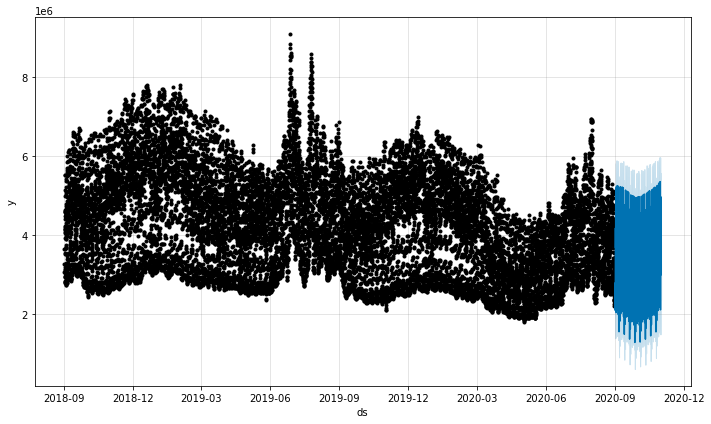

In [ ]:
fig4=model_tot.plot(forecast)

In [ ]:
forecast.drop(['yhat_lower', 'yhat_upper'], axis='columns', inplace=True)
forecast.rename(columns={"ds": "Date", "yhat": "prophet"}, inplace=True)
forecast.to_csv('prophet.csv')